<a href="https://colab.research.google.com/github/megangrannan/Portfolio/blob/master/Customer_Data_Analysis_Coach_Viva_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvertKit Data Analysis

# Project Goals

We will analyze data from ConvertKit's API to answer the following questions:

*   Which tags and topics are the most popular among our email subscribers? 
*  What can we learn about our subscribers' purchasing patterns?
  *   How long were subscribers on our list before making their first purchase? Did this vary by product purchased?
  *   How long have subscribers been on our list, compared across purchasing categories (Product1, Product2, Other, None)?
  *   What percentage of our subscribers have made a purchase? How does this vary in relation to time on our email list?
  *   What can we learn about people who were on our email list but unsubscribed?
* What recommendations can we make based on this analysis?
  
## Project Outline

We will take the following steps to do this analysis:
1.  API Requests - Make API requests to ConvertKit to gather data, and save relevant data in txt files
2.  Import Libraries
3.  Import and Clean Data - Tags: Import and clean data from the two txt files relating to tag data. Merge both into one dataframe. Classify tags into common topic groups.
4.  Data Analysis - Tags : Aggregate data and answer the questions above relating to tag popularity.
5.  Import and Clean Data - Subscribers and Purchases: Import and clean data from the three txt files relating to purchase and subscriber data, merge into one data frame.
6.  Data Analysis - Subscribers and Purchases: Aggregate data and answer the questions above relating to purchases and subscribers

# Code Excerpts

Below are several code excerpts from my work on this project. 

Code exerpts follow the general workflow of the project - gathering data, cleaning/formatting data, and aggregating/analyzing data.

## Gathering Data 

### Subscriber List Requests

We will request data from the subscriber API endpoint in order to get a complete list of current subscribers, plus relevant information about the subscribers. We will make a separate request to get information on people who have unsubscribed. We will merge this list with information on purchases in order to learn more about subscriber purchasing patterns. Later, we will use this list to get individual subscribers' open and click rates for emails.

In [ ]:
# Create dictionary to store subscriber information
subscribers_dict = defaultdict(list)

In [ ]:
# API request for first page of subscribers
api_string = 'https://api.convertkit.com/v3/subscribers?' + api_secret
response = requests.get(api_string)
response_j = response.json()

# Find total number of pages and subscribers
total_pages = response_j['total_pages']
total_subscribers = response_j['total_subscribers']

# Store relevant subscriber info in dictionary
for subscriber in response_j['subscribers']:
  id = subscriber['id']
  subscribers_dict[id].append(subscriber['email_address'])
  subscribers_dict[id].append(subscriber['first_name'])
  subscribers_dict[id].append(subscriber['created_at'])
  subscribers_dict[id].append(subscriber['fields']['legacy_optintime'])

# Make API requests for rest of subscriber pages and store info in dictionary
for i in range(2,total_pages+1):
  api_string = 'https://api.convertkit.com/v3/subscribers?' + api_secret + '&page=' + str(i)
  response = requests.get(api_string)
  response_j = response.json()

  for subscriber in response_j['subscribers']:
    id = subscriber['id']
    subscribers_dict[id].append(subscriber['email_address'])
    subscribers_dict[id].append(subscriber['first_name'])
    subscribers_dict[id].append(subscriber['created_at'])
    subscribers_dict[id].append(subscriber['fields']['legacy_optintime'])

In [ ]:
# Verify we have captured all subscribers
len(subscribers_dict) == total_subscribers

True

In [ ]:
# Save subscriber information in `api_subscribers.txt` 
with open('api_subscribers.txt', 'w') as file:
  json.dump(subscribers_dict, file)

files.download('api_subscribers.txt')

## Cleaning and Formatting Data

### Tag Subscription Data

This is what our tag subscription data looks like before cleaning. The index represents the id number of each tag, column 0 represesnts the total number of subscribers to the tag, and the additional columns represent ids of email users who are subscribed to the tag.

In [ ]:
# Preview data
tag_sub.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263
1329215,5.0,664953676.0,664944388.0,664946778.0,664944371.0,664953653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1232057,8.0,682624456.0,731116161.0,849293315.0,854832464.0,857251011.0,869337471.0,882994752.0,895691263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1304214,4.0,664944375.0,664953712.0,730847005.0,664940675.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202654,6.0,664946778.0,664948042.0,664948044.0,664948045.0,664948047.0,664948048.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429443,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will need to reformat the `tag_sub` dataframe to condense the data into two columns: `total_subscribers` and `subscriber_ids`. Subscriber ids will be stored as a list in this second column. We will clean the data by removing NaN values. Also, we will investigate why the dataframe has 273 rows when there are only 272 tags.

In [ ]:
# Create `user_ids` column to store a list of all user_ids associated with a tag in one column
tag_sub['user_ids'] = tag_sub.iloc[:, 1:].to_numpy().tolist()

In [ ]:
# Remove all other columns containing user ids
tag_sub.drop(tag_sub.iloc[:, 1:264], axis=1, inplace=True)

In [ ]:
# Remove NaN (empty) values from the list of user ids
tag_sub['user_ids'] = tag_sub['user_ids'].apply(lambda x: [i for i in x if str(i) != 'nan'])

In [ ]:
# Rename dataframe columns
tag_sub.rename(columns={0: 'number_subscribers'}, inplace=True)

In [ ]:
# Preview data
tag_sub.sample(5)

,number_subscribers,user_ids
1397957,5.0,"[821581036.0, 829513408.0, 664953628.0, 664953..."
1398259,0.0,[]
1240718,0.0,[]
1277713,1.0,[664944371.0]
1240811,0.0,[]


`tag_sub` has 273 rows, but there are only 272 tags. If we look at the last row of the dataframe, it does not represent a legitimate tag id or data. We will drop this row and now we have 272 rows, as predicted.

In [ ]:
# Check size of dataframe
tag_sub.shape

(273, 2)

In [ ]:
# Examine last few rows of dataframe
tag_sub.tail()

,number_subscribers,user_ids
1453586,2.0,"[676643172.0, 881534901.0]"
1453849,4.0,"[676643172.0, 850689384.0, 851366563.0, 881534..."
1453584,1.0,[676643172.0]
1244470,23.0,"[676643172.0, 683441994.0, 684009238.0, 685836..."
5,NaN,[]


In [ ]:
# Drop last row from dataframe
tag_sub.drop(index='5', inplace=True)

In [ ]:
# Verify results
tag_sub.tail()

,number_subscribers,user_ids
1453585,3.0,"[676643172.0, 850689384.0, 851366563.0]"
1453586,2.0,"[676643172.0, 881534901.0]"
1453849,4.0,"[676643172.0, 850689384.0, 851366563.0, 881534..."
1453584,1.0,[676643172.0]
1244470,23.0,"[676643172.0, 683441994.0, 684009238.0, 685836..."


In [ ]:
# Reformat `number_subscribers` column as integers
tag_sub['number_subscribers'] = tag_sub['number_subscribers'].astype(int)

In [ ]:
# Reformat `user_ids` column as integers
def to_int(tags):
  tag_list = []
  for tag in tags:
    tag = int(tag)
    tag_list.append(tag)
  return tag_list

tag_sub['user_ids'] = tag_sub['user_ids'].apply(to_int)

In [ ]:
# Verify results
tag_sub.sample(5)

,number_subscribers,user_ids
1264538,3,"[664953722, 664944378, 664940675]"
1256151,104,"[664944364, 664953737, 664940675, 664944371, 6..."
1240815,0,[]
1231652,26,"[687487265, 692530513, 726985916, 731116161, 6..."
1261329,22,"[664943368, 717082207, 731116161, 734033266, 7..."


### Merge Data

Now that we have cleaned and formatted `tag_sub` and `tag_data`, we are ready to merge these two dataframes into one.

In [ ]:
# Convert `tag_sub` index to integer type so that index matches `tag_data` for merging
tag_sub.index = tag_sub.index.astype(int)

In [ ]:
# Merge `tag_sub` and `tag_data` into one dataframe
all_tag_data = tag_data.merge(tag_sub, how='left', left_index=True, right_index=True)

In [ ]:
# Preview `all_tag_data`
all_tag_data.sample(5)

,name,Topic,number_subscribers,user_ids
id,,,,
1561864,Link-Video-Recomp-Women,"[Recomp, Women]",10,"[664953628, 664953735, 812597413, 664946781, 6..."
1256389,BoT-Link-Feedback-WantTroubleshootTool,[],0,[]
1261319,Past-CalorieMacroCount,[Calorie],23,"[664944388, 664943368, 726985916, 731116161, 7..."
1259834,BoT-Link-Exercise-Glutes,[Exercise],0,[]
1261332,Need-StepByStepCoach,[Coach],13,"[733396202, 734033266, 779708759, 783470093, 8..."


### Purchase Data

First, we will import the `api_purchases.txt` file where the purchase information is stored. We will then load the data into a dataframe and clean it. We will categorize purchases into `Product1`, `Product2`, and `Other`. Note: Product names have been changed.

In [ ]:
# Import `api_purchases.txt`
uploaded = files.upload()

Saving api_purchases.txt to api_purchases.txt


In [ ]:
# Load results into a python dictionary
purchases = json.loads(uploaded["api_purchases.txt"].decode('utf-8'))

In [ ]:
# Store purchase info in a dataframe
purchases = pd.DataFrame.from_dict(purchases, orient='index')

In [ ]:
# Rename columns
purchases.columns=['email', 'product', 'total_1', 'total_2', 'purchase_time']

In [ ]:
# Verify that we have all 269 purchases in the dataframe
purchases.shape

(269, 5)

In [ ]:
# Drop email - privacy
purchases.drop(columns=['email'], inplace=True)

In [ ]:
# Preview data
purchases.sample(5)

,product,total_1,total_2,purchase_time
10246604,Coach Viva,0.0,36.32,2019-09-05T21:30:10Z
10246744,Coach Viva 25-monthly,0.0,26.03,2019-03-10T22:46:41Z
10246717,Coach Viva,0.0,51.75,2019-04-21T17:56:10Z
10246584,Stripe Payment,14.0,0.00,2019-09-30T05:28:35Z
10246660,Coach Viva,0.0,36.32,2019-07-04T01:56:35Z


Purchase totals were recorded in two different places in our records, depending on how and when the purchase was made. We will clean this information by combining `total_1` and `total_2` into one column with the true total for the purchase. Also, we will need to convert the `purchase_time` column to datetime objects to make it easier to work with. Finally, we will clean up the `product` category by classifying products into the following 3 categories: Product1, Product2, and Other.

In [ ]:
# Combine two total columns into one and drop old total columns
purchases['total'] = purchases['total_1'] + purchases['total_2']
purchases = purchases.drop(['total_1', 'total_2'], axis=1)

In [ ]:
# Write a function to convert the dates into datetime objects
def convert_date(d):
  new_date = dt.datetime.strptime(d, "%Y-%m-%dT%H:%M:%SZ")
  return new_date.date()

In [ ]:
# Apply this function to the `purchase_time` column
purchases['purchase_time'] = purchases['purchase_time'].apply(convert_date)

In [ ]:
# Look at different total amounts to decide how to classify them - output removed for privacy
purchases['total'].value_counts().sort_index()

We will classify all purchases of \$500 or more as Product1, all purchases of \$47 or \$97 as Product2, and all other purchases as Other.

In [ ]:
# Write a function to categorize purchases 
def purchase_cat(x):
  if x >= 500:
    return 'Product1'
  elif x == 47 or x == 97:
    return 'Product2'
  else:
    return 'Other'

In [ ]:
# Use the function to categorize purchases
purchases['purchase_cat'] = purchases['total'].apply(purchase_cat)

In [ ]:
# Drop `product` category as we don't need this anymore
purchases.drop('product', axis=1, inplace=True)

In [ ]:
# Verify results
purchases.sample(5)

,purchase_time,total,purchase_cat
10246723,2019-04-10,26.03,Other
10412504,2019-12-16,69.31,Other
10246661,2019-07-03,26.03,Other
10246549,2019-11-09,69.31,Other
12989055,2020-04-08,600.00,Product1


## Aggregation and Analysis 


### Most Popular Topics

Prior to this, I analyzed the most popular tags and grouped similar tags into topics. Each tag is classified as belonging to a list of topics, as seen in `Topics` column of the dataframe below.

In this section, we will look at the most popular topics to gain a broader view of subscriber interests.

In [ ]:
# Preview `all_tag_data`
all_tag_data.sample(5)

,name,Topic,number_subscribers,user_ids
id,,,,
1561864,Link-Video-Recomp-Women,"[Recomp, Women]",10,"[664953628, 664953735, 812597413, 664946781, 6..."
1256389,BoT-Link-Feedback-WantTroubleshootTool,[],0,[]
1261319,Past-CalorieMacroCount,[Calorie],23,"[664944388, 664943368, 726985916, 731116161, 7..."
1259834,BoT-Link-Exercise-Glutes,[Exercise],0,[]
1261332,Need-StepByStepCoach,[Coach],13,"[733396202, 734033266, 779708759, 783470093, 8..."


First, we need break tags that belong to multiple topics out into one row for each topic. Then, we'll aggregate our data by topic and analyze the findings.

In [ ]:
# Explode list in `Tag_Group` column to prepare to aggregate 
all_tag_data_group = all_tag_data.explode('Topic')

In [ ]:
# Add `% Subscribed` column: percentage of email list subscribed to each tag
all_tag_data_group['% Subscribed'] = round(all_tag_data_group['number_subscribers'] / total_subscribers * 100, 2)

In [ ]:
# Preview data
all_tag_data_group.sample(5)

,name,Topic,number_subscribers,user_ids,% Subscribed
id,,,,,
1304214,Link-Video-Podcast-Episode3,NaN,4,"[664944375, 664953712, 730847005, 664940675]",1.00
1216035,Tendency-Upholder,NaN,32,"[664940672, 664946777, 664948040, 664948048, 6...",8.00
1277719,Feedback-WantOther,NaN,0,[],0.00
1334670,TPPurchased-Course-Lesson-3.7,NaN,0,[],0.00
1261330,Need-Knowledge,NaN,13,"[664944388, 664943368, 731116161, 754416722, 7...",3.25


In [ ]:
# Aggregate data by topic
tag_topics = all_tag_data_group.groupby('Topic')['number_subscribers'].agg(['count','sum'])
tag_topics.columns=['Total_tags', 'Total_subscribers']
tag_topics.sort_values('Total_subscribers', ascending=False, inplace=True)
tag_topics['% Subscribed'] = round(tag_topics['Total_subscribers'] / total_subscribers * 100, 2)
tag_topics

,Total_tags,Total_subscribers,% Subscribed
Topic,,,
Coach,24,375,93.75
Women,2,177,44.25
FatLoss,16,116,29.00
CaseStudy,13,102,25.50
PCOS,5,96,24.00
Cravings,9,93,23.25
Diet,8,62,15.50
Muscle,7,45,11.25
Recomp,5,44,11.00


Above we can see the tag topics, number of tags associated with that topic, number of subscribers to the topic, and percent of total subscribers that are subscribed to the topic. For example, 24% of subscribers are subscribed to PCOS topic tags (see cell below to explore specific tags for a topic). Popular topics include: `PCOS`, `Women`, `FatLoss`, `Cravings`, `CaseStudy`, and `Diet`.

In [ ]:
# To see data for tags associated with a specific topic: put topic name after ==
all_tag_data_group[all_tag_data_group['Topic'] == 'PCOS'].sort_values('number_subscribers', ascending=False )

,name,Topic,number_subscribers,user_ids,% Subscribed
id,,,,,
1231666,PCOS-Yes,PCOS,84,"[689730129, 690703724, 692485528, 692524536, 6...",21.00
1329215,Link-Video-PCOS-LowCarb,PCOS,5,"[664953676, 664944388, 664946778, 664944371, 6...",1.25
1347865,Link-Video-PCOS-Wimpee,PCOS,3,"[664940675, 664944371, 664944381]",0.75
1351800,Link-Video-PCOS-IF,PCOS,2,"[664944388, 664953685]",0.50
1333199,Link-Video-PCOS-InsulinResistanceWeight,PCOS,2,"[664953583, 664944371]",0.50


We can gain some interesting information about subscribers from looking at what tags and topics are most popular. However, subscribers are not consistently subscribed to all relevant tags, and not all of these tags tell us useful information about subscribers. Tags also reflect what email broadcasts have focused on - not what subscribers have chosen to subscribe to - so we cannot infer cause and effect of subscriber interests from this data. This may be an opportunity for Viva to think about how they will want to use tag data in the future, and optimize tag categories and organization while the subscriber list is still a relatively manageable size.

### Subscribers and Purchases

Now that we have combined the subscriber and purchase information into one dataframe, we will investigate:
* How long were users on our email list before they made their first purchase?
* How many of our subscribers are active vs. unsubscribed?
* How does time on email list correlate with the different purchase categories (Product1, Product2, Other, None)?
* How many of our subscribers have made purchases?

Here is our merged purchase and subscriber dataframe:

In [ ]:
purchase_sub.sample(5)

,user_id,status,subscription_date,purchase_time,total,purchase_cat,time_to_buy,time_since_sub
730,882580998,inactive,2020-06-11,NaN,NaN,None,NaT,104 days
281,664953580,active,2019-09-16,2019-09-16,7.00,Other,0 days,373 days
443,865058556,active,2020-05-29,NaN,NaN,None,NaT,117 days
314,664953599,active,2019-03-17,2019-09-27,42.54,Other,194 days,556 days
270,664953757,active,2018-07-04,NaN,NaN,None,NaT,812 days


First, we will filter our results to just look at users who have made a purchase, and identify how long it took them to make their first purchase.

In [ ]:
# Filter the dataframe to only those users that have purchased
made_purchase = purchase_sub[purchase_sub['time_to_buy'].notnull()].copy()

In [ ]:
# Find the first purchase of each client
first = made_purchase.groupby('user_id').agg({'time_to_buy':min})

Let's look more closely at how long customers have been on our email list before they make their first purchase.

In [ ]:
# Number of customers who were on the list for 0, 1, 2, etc. days before making their first purchase
first['time_to_buy'].dt.days.value_counts().sort_index()

0      11
1       5
2       2
3       6
5       3
7       1
8       4
9       6
11      4
12      2
13      1
15      2
26      1
35      1
40      1
50      1
54      1
59      1
167     1
175     1
191     1
205     1
219     1
310     1
418     1
431     1
584     1
605     1
637     1
Name: time_to_buy, dtype: int64

We can see that most customers who make a purchase do so soon after joining our email list. Based on this data, we will sort customers into the following groups:
Those who make their first purchase within 0 days, 1 day, 3 days, 7 days, 14 days, 30 days, 90 days, 180 days, 1 year, and 2 years. We will plot these individual and cumulative groups below.

In [ ]:
# Sort purchases into groups by purchase date
cut_bins=[0, .9, 1.9, 3.9,7.9,14.9,30.9,90.9,180.9,365.9,730.9]
cut_labels=['0 days', '1 day', '3 days', '7 days', '14 days', '30 days', '90 days', '180 days', '1 year', '2 years']
made_purchase['buy_group'] = pd.cut(made_purchase['time_to_buy'].dt.days, bins=cut_bins, labels=cut_labels, include_lowest=True)
first['buy_group'] = pd.cut(first['time_to_buy'].dt.days, bins=cut_bins, labels=cut_labels, include_lowest=True)

In [ ]:
# Percentage of customers who make their first purchase within the given time bucket
sorted_first_purchase = first['buy_group'].value_counts(normalize=True).iloc[[1,5,2,-3,0,-2,4,-1,-4,3]]
sorted_first_purchase = round(sorted_first_purchase * 100, 2)
sorted_first_purchase

0 days      17.19
1 day        7.81
3 days      12.50
7 days       6.25
14 days     26.56
30 days      4.69
90 days      7.81
180 days     3.12
1 year       6.25
2 years      7.81
Name: buy_group, dtype: float64

In [ ]:
# Cumulative percentage of customers who make their first purchase within the given timeframe
np.cumsum(sorted_first_purchase)

0 days      17.19
1 day       25.00
3 days      37.50
7 days      43.75
14 days     70.31
30 days     75.00
90 days     82.81
180 days    85.93
1 year      92.18
2 years     99.99
Name: buy_group, dtype: float64

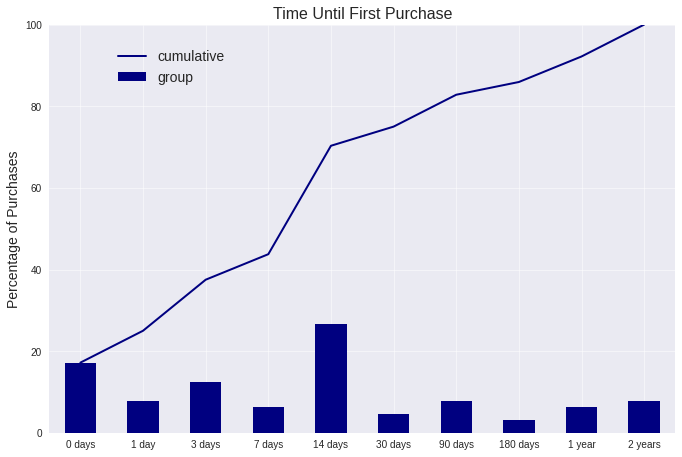

In [ ]:
# Create plot to visualize time until first purchase
fig, ax = plt.subplots(figsize=(10,7))
sorted_first_purchase.plot.bar(ax=ax, rot=30, label = 'group', color='navy')
np.cumsum(sorted_first_purchase).plot(ax=ax, label = 'cumulative', color='navy')
plt.ylabel('Percentage of Purchases', fontsize=14)
plt.title('Time Until First Purchase', fontsize=16)
plt.ylim(0,100)
plt.legend(fontsize=14, bbox_to_anchor=(.3, .97))
plt.show()

Of our users who made a purchase:
* 25% made their first purchase within 0 or 1 days of being on our email list
* 44% made thier first purchase within 1 week of being on our email list
* 75% made their first purchase within 1 month of being on our email list
* 92% made their first purchase within 1 year of being on our email list


Next, we will look at how long customers were on our email list before purchasing for different products.

In [ ]:
purchase_group = pd.DataFrame(made_purchase.groupby(['purchase_cat', 'buy_group'])['user_id'].nunique())
purchase_group['percent_group'] = purchase_group.groupby(level=0).apply(lambda x: round(x * 100 / x.sum(), 2))
purchase_group

user_id  percent_group
purchase_cat buy_group                        
Other        0 days           7           6.25
             1 day            2           1.79
             3 days           2           1.79
             7 days           1           0.89
             14 days         14          12.50
             30 days          5           4.46
             90 days         27          24.11
             180 days        26          23.21
             1 year          18          16.07
             2 years         10           8.93
Product1     0 days           0           0.00
             1 day            4          22.22
             3 days           6          33.33
             7 days           3          16.67
             14 days          3          16.67
             30 days          0           0.00
             90 days          1           5.56
             180 days         0           0.00
             1 year           0           0.00
             2 years          1           5.56
Product2     0 days           4          66.67
             1 day            0           0.00
             3 days           0           0.00
             7 days           0           0.00
             14 days          0           0.00
             30 days          0           0.00
             90 days          0           0.00
             180 days         0           0.00
             1 year           1          16.67
             2 years          1          16.67

Customers who purchased Product1 tended to have been on our email list for 2 weeks or less at the time of purchase. About half purchased within 2 days of being on the list. It is possible that many of these customers were added to the email list upon purchasing Product1, or scheduling a sales call for Product1. Most of Product2 customers seemed to have joined our email list when they made a purchase, although 2 people did make this purchase after being on our list for a longer time. In contrast, customers who purchased Other products tended to have been on our email list longer. Many of these customers may represent chat coaching clients from our old email list, along with customers who have purchased lower value products.